In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Constants
NUM_GAMES = 150000
BATCH_SIZE = 32
LR = 1e-6

In [3]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [4]:
def process_match(match_index):
    with open('data/matches/' + str(match_index) + '.txt', 'r') as f:
        rows = f.read().split('\n')
        vec = []
        for j in range(10):
            champ_vec = get_champ_vec(rows[j])
            for e in champ_vec:
                vec.append(e)
        if rows[10] == 'true':
            vec.append(1)
        else:
            vec.append(0)
        return vec

In [5]:
def process_row(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'float32'))

In [6]:
def get_dataset():
    tmp = []
    for i in range(NUM_GAMES):
        try:
            tmp.append(process_match(i))
        except:
            pass
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_row)
    ds = ds.cache()
    ds = ds.shuffle(NUM_GAMES)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
ds = get_dataset()

In [8]:
# Partition Dataset
train_size = int(len(ds)*0.7)
val_size = int(len(ds)*0.2)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)

In [9]:
print(train_size, val_size, test_size)

3280 937 470


In [12]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(170, activation='relu', input_dim=170))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [13]:
model = create_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 170)               29070     
                                                                 
 dense_1 (Dense)             (None, 64)                10944     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 41,071
Trainable params: 41,071
Non-trainable params: 0
_________________________________________________________________


In [15]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)

In [16]:
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [26]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
3280/3280 [==============================] - 44s 13ms/step - loss: 0.6952 - binary_accuracy: 0.5018 - val_loss: 0.6949 - val_binary_accuracy: 0.5037
Epoch 2/100
3280/3280 [==============================] - 27s 8ms/step - loss: 0.6947 - binary_accuracy: 0.5036 - val_loss: 0.6949 - val_binary_accuracy: 0.5020
Epoch 3/100
3280/3280 [==============================] - 13s 4ms/step - loss: 0.6945 - binary_accuracy: 0.5042 - val_loss: 0.6946 - val_binary_accuracy: 0.5027
Epoch 4/100
3280/3280 [==============================] - 13s 4ms/step - loss: 0.6943 - binary_accuracy: 0.5049 - val_loss: 0.6944 - val_binary_accuracy: 0.5040
Epoch 5/100
3280/3280 [==============================] - 19s 6ms/step - loss: 0.6943 - binary_accuracy: 0.5041 - val_loss: 0.6945 - val_binary_accuracy: 0.5016
Epoch 6/100
3280/3280 [==============================] - 21s 6ms/step - loss: 0.6939 - binary_accuracy: 0.5063 - val_loss: 0.6942 - val_binary_accuracy: 0.5035
Epoch 7/100
3280/3280 [================

Epoch 52/100
3280/3280 [==============================] - 21s 6ms/step - loss: 0.6920 - binary_accuracy: 0.5190 - val_loss: 0.6918 - val_binary_accuracy: 0.5213
Epoch 53/100
3280/3280 [==============================] - 21s 7ms/step - loss: 0.6922 - binary_accuracy: 0.5177 - val_loss: 0.6922 - val_binary_accuracy: 0.5162
Epoch 54/100
3280/3280 [==============================] - 22s 7ms/step - loss: 0.6921 - binary_accuracy: 0.5184 - val_loss: 0.6916 - val_binary_accuracy: 0.5242
Epoch 55/100
3280/3280 [==============================] - 19s 6ms/step - loss: 0.6920 - binary_accuracy: 0.5185 - val_loss: 0.6921 - val_binary_accuracy: 0.5183
Epoch 56/100
3280/3280 [==============================] - 21s 7ms/step - loss: 0.6919 - binary_accuracy: 0.5189 - val_loss: 0.6917 - val_binary_accuracy: 0.5224
Epoch 57/100
3280/3280 [==============================] - 19s 6ms/step - loss: 0.6919 - binary_accuracy: 0.5204 - val_loss: 0.6919 - val_binary_accuracy: 0.5183
Epoch 58/100
3280/3280 [==========

In [27]:
history_dict = history.history

In [28]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

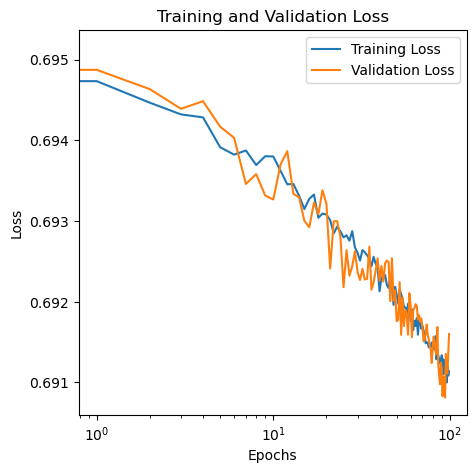

In [29]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

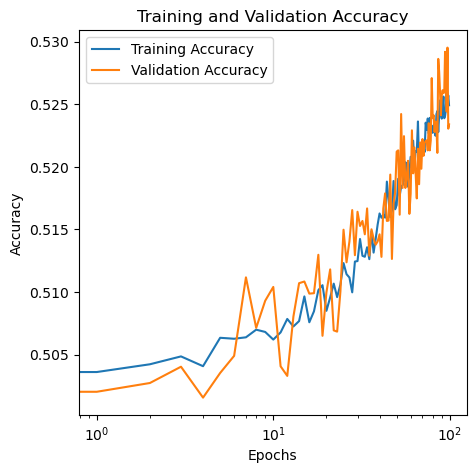

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

470/470 [==============================] - 1s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5259
Loss: 0.6913020610809326
Accuracy: 0.5259062051773071
